calculate point cloud

## todo 
a) Why are we always referring to “qualitative measurements” in this homework? Why are our
measurements qualitative? What would we need to do to get quantitative measurements?
Brainstorm suggestions how to achieve this. (5 pts)


b) Why could a qualitative setup like this still be useful? What can you “see” with this setup that you
cannot “see” with your eye or a normal camera? 


c) Give examples for elements of the null space in Deflectometry by reviewing again the geometry of
your setup. (5 pts)

## Part IV e and f
Fun and extra points (does not need to be answered to get full points for this HW) (2 pts):
Why does Phase Measuring Deflectometry (the method implemented in this homework) requires
phase shifted sinusoid patterns on horizontal and verical direction to establish correspondence,
while Fringe Projection Triangulation on matte surfaces requires only phase shifted sinusoids in
one direction?

Fun and extra points (does not need to be answered to get full points for this HW) (2 pts):
Give us feedback! What did you like/not like in this HW? What was unclear? Was the HW too
long/too short? Problems too easy/too hard? Were the explanations clear?

## Part IV d , this part save the point cloud normal to ply and open in meshlab

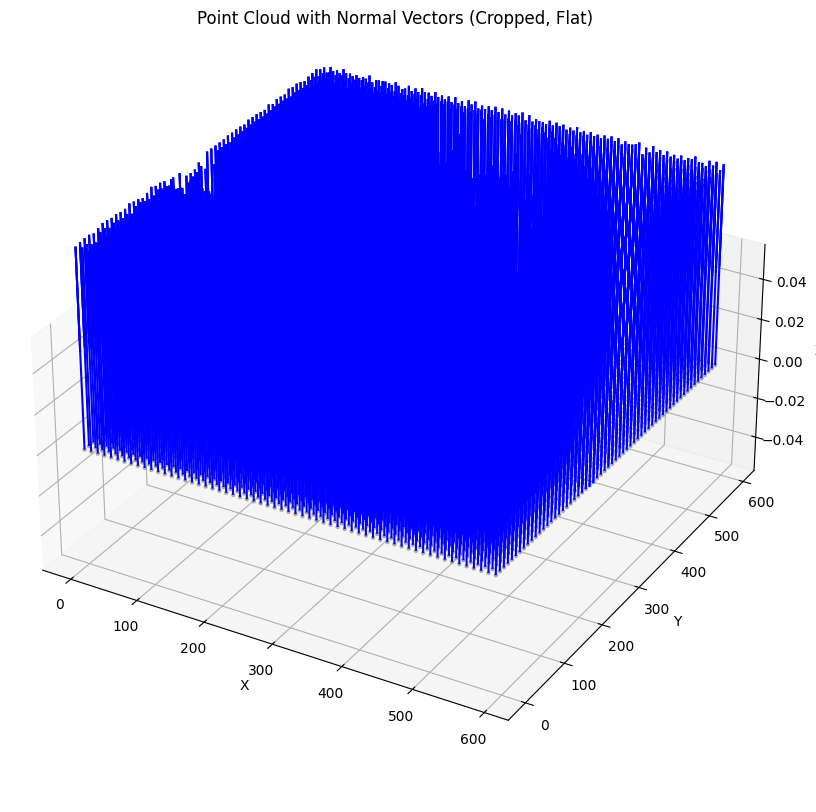

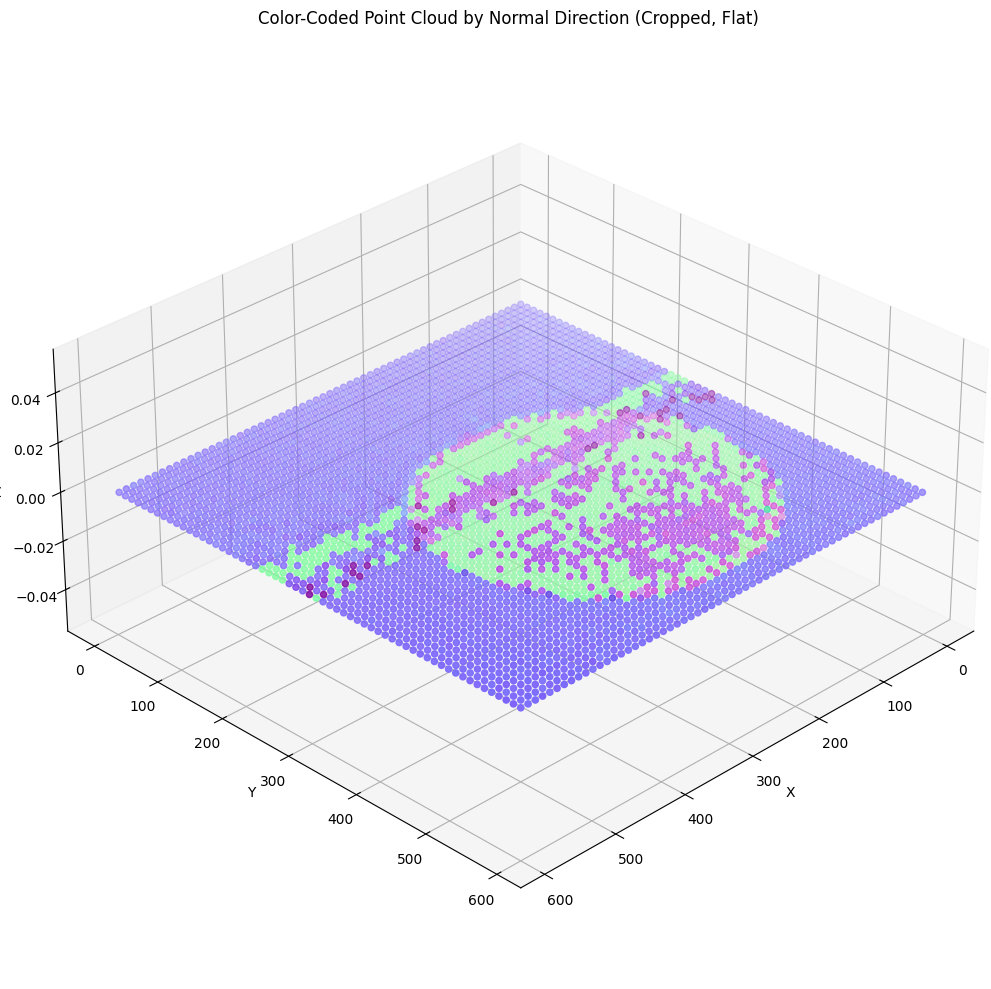

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

# Define crop coordinates
x_start, x_end = 2000, 2600
y_start, y_end = 1300, 1900

# Step 1: Load and crop the four phase images as PNG files
phi_h_r_full = np.array(Image.open('phi_h_r.png').convert('L')) / 255.0 * 2 * np.pi
phi_v_r_full = np.array(Image.open('phi_v_r.png').convert('L')) / 255.0 * 2 * np.pi
phi_h_o_full = np.array(Image.open('phi_h_o_coin_1.png').convert('L')) / 255.0 * 2 * np.pi
phi_v_o_full = np.array(Image.open('phi_v_o_coin_1.png').convert('L')) / 255.0 * 2 * np.pi

# x_start, x_end = 0, phi_h_r_full.shape[0]
# y_start, y_end = 0, phi_h_r_full.shape[1]

# Apply cropping
phi_h_r = phi_h_r_full[y_start:y_end, x_start:x_end]
phi_v_r = phi_v_r_full[y_start:y_end, x_start:x_end]
phi_h_o = phi_h_o_full[y_start:y_end, x_start:x_end]
phi_v_o = phi_v_o_full[y_start:y_end, x_start:x_end]

# Part b: Calculate rho_v and rho_h
rho_v = -(phi_v_o - phi_v_r)  # dz/dy (vertical slope)
rho_h = -(phi_h_o - phi_h_r)  # dz/dx (horizontal slope)

# Part c: Calculate surface normal map
denominator = np.sqrt(rho_v**2 + rho_h**2 + 1)
nx = rho_v / denominator
ny = rho_h / denominator
nz = 1 / denominator

# Create a flat point cloud at z = 0
height, width = phi_h_o.shape  # Cropped size (600x600)
y, x = np.mgrid[0:height, 0:width]
z = np.zeros_like(x)  # Flat surface at z=0

# Subsample for export and visualization
step = 10
x_sub = x[::step, ::step]
y_sub = y[::step, ::step]
z_sub = z[::step, ::step]
nx_sub = nx[::step, ::step]
ny_sub = ny[::step, ::step]
nz_sub = nz[::step, ::step]

# Create RGB colors from normals for visualization
colors = np.zeros((x_sub.shape[0], x_sub.shape[1], 3))
colors[:,:,0] = (nx_sub + 1) / 2  # R channel
colors[:,:,1] = (ny_sub + 1) / 2  # G channel
colors[:,:,2] = (nz_sub + 1) / 2  # B channel
colors = (colors * 255).astype(np.uint8)  # Convert to 0-255 range for PLY

# Flatten arrays for export
x_flat = x_sub.flatten()
y_flat = y_sub.flatten()
z_flat = z_sub.flatten()
nx_flat = nx_sub.flatten()
ny_flat = ny_sub.flatten()
nz_flat = nz_sub.flatten()
colors_flat = colors.reshape(-1, 3)

# Save point cloud with normals and colors to PLY file
def save_point_cloud_to_ply(filename, x, y, z, nx, ny, nz, colors):
    num_points = len(x)
    with open(filename, 'w') as f:
        # Write PLY header
        f.write("ply\n")
        f.write("format ascii 1.0\n")
        f.write(f"element vertex {num_points}\n")
        f.write("property float x\n")
        f.write("property float y\n")
        f.write("property float z\n")
        f.write("property float nx\n")
        f.write("property float ny\n")
        f.write("property float nz\n")
        f.write("property uchar red\n")
        f.write("property uchar green\n")
        f.write("property uchar blue\n")
        f.write("end_header\n")
        # Write vertex data
        for i in range(num_points):
            f.write(f"{x[i]} {y[i]} {z[i]} {nx[i]} {ny[i]} {nz[i]} "
                    f"{int(colors[i, 0])} {int(colors[i, 1])} {int(colors[i, 2])}\n")

# Export to PLY file
save_point_cloud_to_ply('coin_1_point_cloud_with_normals_flat.ply', x_flat, y_flat, z_flat, 
                        nx_flat, ny_flat, nz_flat, colors_flat)

# Create point cloud visualization with normal vectors
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the flat point cloud
ax.scatter(x_sub, y_sub, z_sub, c='gray', s=5, alpha=0.5)

# Plot normal vectors as arrows
ax.quiver(x_sub, y_sub, z_sub, nx_sub, ny_sub, nz_sub, 
          length=0.1,  # Adjusted for visibility
          normalize=True, 
          color='b', 
          arrow_length_ratio=0.5)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Point Cloud with Normal Vectors (Cropped, Flat)')

# Set equal aspect ratio
ax.set_box_aspect([1, 1, 0.5])

# Add a second visualization with color-coded normals
fig2 = plt.figure(figsize=(12, 10))
ax2 = fig2.add_subplot(111, projection='3d')

# Plot color-coded point cloud
colors_normalized = colors_flat / 255.0  # Normalize back to 0-1 for matplotlib
ax2.scatter(x_flat, y_flat, z_flat, c=colors_normalized, s=20)

# Set labels and title
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Color-Coded Point Cloud by Normal Direction (Cropped, Flat)')

# Set equal aspect ratio
ax2.set_box_aspect([1, 1, 0.5])

# Adjust viewing angle
ax2.view_init(elev=30, azim=45)

plt.tight_layout()
fig.savefig('coin_1_point_cloud_with_normals_cropped_flat.png')
fig2.savefig('coin_1_color_coded_point_cloud_cropped_flat.png')

plt.show()